Here we shall learn the stochastic dynamics of the one-dimensional Fredrickson-Andersen (FA) model, consisting of binary spins on a lattice, through observation of a single trajectory. The trajectory of length $T$, obtained through kinetic (or continuous-time) Monte Carlo, consists of configurations and their associated residence times:
\begin{equation*}
\omega = \mathcal{C}_0  \xrightarrow[]{\Delta t_{\mathcal{C}_0}} \mathcal{C}_1 \xrightarrow[]{\Delta t_{\mathcal{C}_1}} \cdots\mathcal{C}_{K-1} \xrightarrow[]{\Delta t_{\mathcal{C}_{K-1}}}\mathcal{C}_K \xrightarrow[]{\Delta t_{K}} \mathcal{C}_K
\end{equation*}
where $\Delta t_{K} = T-\sum_{k=0}^{K-1} \Delta t_{\mathcal{C}_k}$. The trajectory log-likelihood is given by 
\begin{equation*}
U_\omega =\sum_{k=0}^{K-1} \left(\ln W_{\mathcal{C}_k \to \mathcal{C}_{k+1}}-\Delta t_{\mathcal{C}_k} R_{\mathcal{C}_k}\right)  - \Delta t_K R_{\mathcal{C}_K}
\end{equation*}
where $ W_{\mathcal{C}_k \to \mathcal{C}_{k+1}}$ is the transition rate between configurations $\mathcal{C}_k$ and $\mathcal{C}_{k+1}$, and $R_{\mathcal{C}_k} \equiv \sum_{\mathcal{C}'} W_{\mathcal{C}_k \to \mathcal{C}'}$, the sum running over all transitions allowed from $\mathcal{C}_k$. 

For the FA model, the transition rate for flipping a spin depends only on the state of its nearest neighbours.  The table below contains the rate for all possible processes, where $c$ is a constant equal to the average number of up-spins. We employ periodic boundary conditions in our simulations.

| Process | Rate | 
| --- | --- | 
| `000` $\rightarrow$ `010` | 0 |
| `010` $\rightarrow$ `000` | 0 |
| `001` $\rightarrow$ `011` | $c$ |
| `100` $\rightarrow$ `110`| $c$ |
| `101` $\rightarrow$ `111`| $2c$ |
| `110` $\rightarrow$ `100` | $1-c$ |
| `011` $\rightarrow$ `001`| $1-c$ |
| `111` $\rightarrow$ `101`| $2(1-c)$ |


In [1]:
import numpy as np

def transition_rates_and_R(config,c):
    L = config.shape[0]
    transition_rates = (config*(1-c) + (1-config)*c) * ((np.roll(config, 1) + np.roll(config, -1)))
    R = np.sum(transition_rates)
    return transition_rates, R



def sample_FA_trajectory(T,L,c):
    t = 0
    log_likelihood = 0
    configs = np.zeros((int(T*L*c*1.5), L))
    times = np.zeros((configs.shape[0]))

    i = 0
    config = np.random.choice([0,1], L, p= [1-c,c])
    configs[i] = config

    transition_rates, R = transition_rates_and_R(config,c)

    dt = np.random.exponential(scale = 1/R, size = 1)[0]

    while t + dt < T:

        times[i] = dt
        flip_id = np.random.choice(L, 1, p = transition_rates/R)[0]
        log_likelihood += np.log(transition_rates[flip_id]) - times[i]*R

        t += dt
        i+=1

        config = config.copy()
        config[flip_id] = 1 - config[flip_id]
        configs[i] = config
        transition_rates, R = transition_rates_and_R(config,c)
        dt = np.random.exponential(scale = 1/R, size = 1)[0]

    times[i] = T-t
    log_likelihood -= R*times[i]

    return configs[:i+1],times[:i+1], log_likelihood


In order to learn these dynamics without making assumptions such as locality of the interactions or translational invariance, we must use an efficient way of encoding all the possible transition rates (the number of which grows exponentially with system size). Here, we do so using a neural network. The neural network used to encode the dynamics is a transformer. It consists of multiple layers:
- We first embed the particles' states and positions into a higher-dimensional space. This is done by using `torch.nn.embedding` layers. The embedding of the state and position are added together.
- These embeddings are passed to a `torch.nn.TransformerEncoderLayer`. This layer combines multi-head attention with fully-connected networks and layer normalization acting on the output of the attention layers for each particle. This step can be repeated multiple times; the features of the previous layer are then used as input for the next one.
- Finally, we use a fully-connected neural network acting on the output features of the transformer to calculate the log-rate $\ln W$ for each possible transition; for the specific case of the FA model, this consists of flipping each spin. The output of the model is hence a new sequence which contains the log-rate for flipping each spin of the original sequence.

Through the attention layers, the transformer needs to decide which spins affect the transition rate for flipping a certain spin; we do not provide any prior information about locality of interaction, translation invariance, or the boundary conditions. If such prior physical information would be available, it can easily be incorporated into the model (e.g. by restricting the range of the attention).


In [2]:
import torch
from tqdm import tqdm

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dtype = torch.float32

class TransformerModel(torch.nn.Module):
    def __init__(self, input_dim, seq_length, embedding_dim, num_heads, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()


        self.seq_length = seq_length
        self.spin_emb = torch.nn.Embedding(input_dim, embedding_dim)
        self.pos_emb = torch.nn.Embedding(seq_length, embedding_dim)

        encoder_layers = torch.nn.TransformerEncoderLayer(embedding_dim, num_heads, dim_feedforward, dropout=0, batch_first = True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layers, num_layers)

        #the decoder calculates ln W for a certain transition by processing the output features of the transformer. Here, we can do this with just a single-layer fully-connected net.
        model = []
        model += [torch.nn.Linear(embedding_dim, 1)]
        self.decoder = torch.nn.Sequential(*model)

    def forward(self, x):

        #embed the particles' state and position
        spin_emb = self.spin_emb(x)
        b,t,k = spin_emb.size()
        positions = torch.arange(self.seq_length, device=device)
        pos_emb = self.pos_emb(positions)[None, :,:].expand(b,t,k)

        input = spin_emb + pos_emb

        #calculate the transformer features
        output = self.transformer(input)

        #calculate the transition rates
        output = self.decoder(output)
        return output



cpu


When provided with a trajectory consisting of configurations and residence times, we can optimize the transformer to learn the dynamics which generated this trajectory. We do so by minimizing the negative log-likelihood of the trajectory as calculated by the transformer through gradient descent. As transformers use a large amount of memory, we do this calculation in smaller batches. We then have two options for updating the transformer's weights:
- We update the weights after processing each batch in order to maximize the log-likelihood of the shorter trajectory contained in this batch.
- We store the gradients corresponding to each batch, and only update the weights once the full trajectory is processed.

The second option naturally leads to more accurate gradients to maximize the log-likelihood of the provided trajectory, but requires extensive computation for each weight update. We typically start by using the first option, where we aggregate the gradients of only a few batches before each weight update, to quickly get near the maximum trajectory likelihood. The second option is then used for further fine-tuning of the weights.

In [3]:

class DynamicsLearner(torch.nn.Module):
    def __init__(self,configs,times, exact, T, input_dim, embedding_dim, num_heads, num_layers, dim_feedforward):
        super(DynamicsLearner, self).__init__()

        self.L = configs[0].shape[0]

        self.transformer_logrates = TransformerModel(input_dim, self.L, embedding_dim, num_heads, num_layers, dim_feedforward)
        self.transformer_logrates.to(dtype).to(device)

        self.times = torch.from_numpy(times).to(dtype)
        self.configs = torch.from_numpy(configs).to(torch.int64)
        self.exact = exact
        self.T = T

    #calculate the possible transition (log) rates and escape rate for a batch of configurations
    def log_transition_rates_and_R_batched(self, configs):
        configs = configs.to(device)
        log_rates = self.transformer_logrates(configs)[...,0]
        R = torch.sum(torch.exp(log_rates), dim =1)
        return log_rates, R


    #calculate log-likelihood of part of the trajectory; \sum_k ln W_{C_k->C+{k+1}} - R \Delta t_{C_k}
    def log_likelihood_trajectory_batched(self, start, end, calc_last = False):
        log_transition_rates, R = self.log_transition_rates_and_R_batched(self.configs[start:end])
        if not calc_last:
            #check which spin has flipped for each transition
            ids_flipped = torch.where(self.configs[start:end] - self.configs[start+1:end + 1])
            
            log_likelihood = log_transition_rates[ids_flipped].sum() - (self.times[start:end].to(device)*R).sum()
        else:
            ids_flipped = torch.where(self.configs[start:end-1] - self.configs[start+1:end])
            log_likelihood = log_transition_rates[:-1][ids_flipped].sum() - (self.times[start:end-1].to(device)*R[:-1]).sum()
            log_likelihood -= R[-1]*self.times[-1].to(device)
        return log_likelihood



    def train_batched(self, n_iter, lr, batch_size,update_batch, batch_per_update, grad_clip):
        #use the Adam optimizer to train the net
        optimizer = torch.optim.Adam(self.parameters(), lr)

        losses = np.zeros(n_iter)
        
        steps = self.times.shape[0] // batch_size + 1  if batch_size < self.times.shape[0] else 1

        for i in range(n_iter):

            running_loss = 0

            for j in tqdm(range(steps)):

                #calculate the loss on each batch (i.e. part of the trajectory)
                #multiply loss by -1 as we want to minimize the negative log-likelihood
                if j < steps - 1:
                    loss = -1* (self.log_likelihood_trajectory_batched(j*batch_size, (j+1)*batch_size))
                else:
                    loss = -1 *(self.log_likelihood_trajectory_batched(j*batch_size, self.times.shape[0], calc_last = True))


                loss.backward()

                if update_batch and j % batch_per_update == 0:
                    #update weights on smaller parts of the trajectory, and reset gradients

                    if grad_clip != 0:
                        torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                    optimizer.step()
                    optimizer.zero_grad()


                running_loss += loss.detach()

            
            if not update_batch:
                #update weights based on log-likelihood of the full trajectory
                if grad_clip != 0:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                optimizer.step()
                optimizer.zero_grad()


            tot_loss = running_loss.cpu().numpy()

            losses[i] = tot_loss

            print("Step: "+ str(i+1)+"\t Exact: " + str(self.exact/self.T) + "\t"+"Transformer: " + str(-1*tot_loss/self.T))
        return losses

In [4]:
#generate a trajectory

T = 1e4
L = 10
c = 0.3

configs,times, exact = sample_FA_trajectory(T, L, c)


#define the model parameters

input_dim =2 #number of spin states (here = 2 for binary spins)
embedding_dim = 64 
num_heads = 4
num_layers = 2
dim_feedforward = int(4*embedding_dim)

dynamics = DynamicsLearner(configs,times, exact, T, input_dim, embedding_dim, num_heads, num_layers, dim_feedforward)

#first do optimization on batches of the full trajectory
num_iter = 10
lr = 5e-4
batch_size = int(1e3)
update_batch = True
batch_per_update = 1
grad_clip = 100 
losses_batched = dynamics.train_batched(num_iter,lr , batch_size,update_batch, batch_per_update, grad_clip)

#then fine-tune weights on full trajectory
num_iter = 10
lr = 1e-4
losses_full = dynamics.train_batched(num_iter,lr , batch_size,False, 0, grad_clip)

losses = np.concatenate((losses_batched, losses_full))

100%|██████████| 27/27 [00:05<00:00,  4.73it/s]


Step: 1	 Exact: -4.094894563785684	Transformer: -5.9676828125


100%|██████████| 27/27 [00:05<00:00,  5.37it/s]


Step: 2	 Exact: -4.094894563785684	Transformer: -5.246193359375


100%|██████████| 27/27 [00:04<00:00,  5.54it/s]


Step: 3	 Exact: -4.094894563785684	Transformer: -4.6102640625


100%|██████████| 27/27 [00:04<00:00,  5.95it/s]


Step: 4	 Exact: -4.094894563785684	Transformer: -4.24027890625


100%|██████████| 27/27 [00:04<00:00,  5.90it/s]


Step: 5	 Exact: -4.094894563785684	Transformer: -4.162585546875


100%|██████████| 27/27 [00:04<00:00,  6.16it/s]


Step: 6	 Exact: -4.094894563785684	Transformer: -4.141698046875


100%|██████████| 27/27 [00:05<00:00,  4.51it/s]


Step: 7	 Exact: -4.094894563785684	Transformer: -4.1309265625


100%|██████████| 27/27 [00:07<00:00,  3.84it/s]


Step: 8	 Exact: -4.094894563785684	Transformer: -4.1256421875


100%|██████████| 27/27 [00:06<00:00,  3.94it/s]


Step: 9	 Exact: -4.094894563785684	Transformer: -4.12470390625


100%|██████████| 27/27 [00:05<00:00,  5.21it/s]


Step: 10	 Exact: -4.094894563785684	Transformer: -4.11891171875


100%|██████████| 27/27 [00:04<00:00,  6.31it/s]


Step: 1	 Exact: -4.094894563785684	Transformer: -4.10886875


100%|██████████| 27/27 [00:04<00:00,  6.37it/s]


Step: 2	 Exact: -4.094894563785684	Transformer: -4.103628125


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


Step: 3	 Exact: -4.094894563785684	Transformer: -4.101100390625


100%|██████████| 27/27 [00:04<00:00,  6.08it/s]


Step: 4	 Exact: -4.094894563785684	Transformer: -4.10012734375


100%|██████████| 27/27 [00:04<00:00,  6.23it/s]


Step: 5	 Exact: -4.094894563785684	Transformer: -4.099421484375


100%|██████████| 27/27 [00:04<00:00,  6.41it/s]


Step: 6	 Exact: -4.094894563785684	Transformer: -4.0988484375


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


Step: 7	 Exact: -4.094894563785684	Transformer: -4.098819140625


100%|██████████| 27/27 [00:04<00:00,  5.95it/s]


Step: 8	 Exact: -4.094894563785684	Transformer: -4.09855546875


100%|██████████| 27/27 [00:04<00:00,  6.25it/s]


Step: 9	 Exact: -4.094894563785684	Transformer: -4.098248828125


100%|██████████| 27/27 [00:04<00:00,  5.53it/s]

Step: 10	 Exact: -4.094894563785684	Transformer: -4.097953125


Once training is finished, we can evaluate the trajectory log-likelihood for both the exact dynamics and those learned with the transformer.

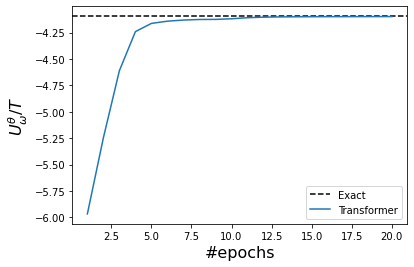

In [6]:
import matplotlib.pyplot as plt

plt.axhline(exact/T, ls = "--", color="k", label = "Exact")
plt.plot(np.arange(losses.shape[0])+1,-1*losses/T, label = "Transformer")
plt.xlabel("#epochs", fontsize = 16)
plt.ylabel(r"$U_\omega^\theta/T$", fontsize = 16)
plt.legend(loc="best")
plt.show()